## Energy Innovation MCOE Compilation

- <a href=#setup>Setup</a>
- <a href=#data_out>Data Outputs</a>
    * <a href=#final-plant>Plant Level Output</a>
    * <a href=#final-unit>Unit Level Output</a>
    * <a href=#export>Export to CSV</a>
- <a href=#data_comp>Data Components</a>
    * <a href=#part1>Part 1: Basic Plant & Unit Information</a>
    * <a href=#part2>Part 2: Cost Data</a>
    * <a href=#part3>Part 3: Emissions & Public Health Data</a>
- <a href=#data_val>Data Validation</a>
    * <a href=#ferc-v-eia>FERC Form 1 vs. EIA</a>
    * <a href=#mcoe-validate>MCOE Validation</a>

-------------

## <a id='setup'>Setup</a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pudl
import sqlalchemy as sa
from ei_mcoe import *
import sys
import os
import matplotlib.pyplot as plt
import logging
import requests

/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# basic setup for logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]
pd.options.display.max_columns = None

In [4]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

In [5]:
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine, freq='AS', fill=True, roll=True)

## <a id='data_out'>Data Outputs</a>

In [6]:
%%time
cems_df = get_cems(pudl_settings)

Getting CEMS data....this may take a sec.


/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


CPU times: user 18.6 s, sys: 2.86 s, total: 21.5 s
Wall time: 3min 8s


### <a id='final-plant'>Plant Level Output</a>

In [8]:
%%time
plant = main(pudl_out, cems_df, 'plant-fuel', separate_nems_cols=True)

Prepping raw EIA data
filling in fuel cost NaNs EIA APIs monthly state averages
filling in fuel cost NaNs with rolling averages
Converting date to year
Calculating generator age
Eliminating retired plants
Converting date to year
Building Part 1 output
Finished compiling Part 1 plant-fuel level data
Cleaning Part 1 Output
Finished cleaning Part 1 data
Building Part 3 output
 - Adding cems to EIA data
 - Adding pm values to the dataframe
 -- Calculating tech percents
 -- Calculating pm2.5 values


/Users/christinagosnell/code/ei-mcoe-map/ei_mcoe.py:1874: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pm_df.assign(


 - Calculating public health damages from emissions
 - Calculating the amount of premature deaths
Finished building Part 3 plant-fuel level data
Cleaning Part 3 output
Finished cleaning Part 3 output
Building Part 2 output
 - Building eia table broken down by plant and fuel type
 - Building FERC table broken down by plant
 - Readying EIA fuel pct data to merge with FERC
 - Building eia table broken down by plant and fuel type
 -- Calculating eia fuel type percentages
Turning eia fuel percent values for net_generation_mwh into columns
Turning eia fuel percent values for capacity_mw into columns
 - Merging FERC Form 1 data with EIA percent data
 -- Building FERC table broken down by plant and fuel type
 -- Melting FERC pct data back to row values
 -- Melting FERC pct data back to row values
 - Merging FERC and EIA mcoe data on plant and fuel type
 - Adding NEMS cost data
checking nems inside add_nems
Id's from NEMS:    5476
Ids w/ NEMS data:  4945
Ids w/o NEMS data: 5509
Missing ids:    

### <a id='final-unit'>Unit Level Output</a>

In [10]:
unit = main(pudl_out, cems_df, 'unit-fuel', separate_nems_cols=True)

Prepping raw EIA data
Converting date to year
Calculating generator age
Eliminating retired plants
Converting date to year
Building Part 1 output
Finished compiling Part 1 unit-fuel level data
Cleaning Part 1 Output
Finished cleaning Part 1 data
Building Part 3 output
 - Adding cems to EIA data
 - Adding pm values to the dataframe
 -- Calculating tech percents
 -- Calculating pm2.5 values


/Users/christinagosnell/code/ei-mcoe-map/ei_mcoe.py:1874: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pm_df.assign(


 - Calculating public health damages from emissions
 - Calculating the amount of premature deaths
Finished building Part 3 unit-fuel level data
Cleaning Part 3 output
Finished cleaning Part 3 output
Finished compiling all parts!


### <a id='export'>Export to CSV</a>

In [11]:
source_df = generate_source_df()
plant_18 = plant[plant.report_year == 2018]

plant_18.to_csv('mcoe_compilation.csv',index=False)
unit.to_csv('unit_attributes_mcoe.csv',index=False)
source_df.to_csv('mcoe_documentation.csv', index=False)

Generating separate source dataframe


-------------------------

## <a id='data_comp'>Data Components</a>

### <a id='part1'>Part 1: Plant & Unit Level Data</a>
EIA-860 and EIA-923 generator-level data is aggregated by either plant or unit and subdivided by broad fuel type (coal, gas, oil, waste). 
[`Age`] is calculated by finding the weighted average (capacity as weight) of the generators in a given aggregation. 
[`Heat Rate`] is also calculated by weighted average (this time with net generation as weight). 
[`MW Nameplate Capacity`] and [`Annual Electricity Net Generation MWh`] at a given level of aggregation are calculated by summing generator-level data. 

For purely qualitative information (just plant name and location) add [`drop_calcs=True`] to the parameters.

### <a id='part2'>Part 2: Cost Data</a>
Cost and generation data from EIA-860, EIA-923, and FERC Form 1 are subdivided by plant and broad fuel type. The fuel-type breakdown for FERC Form 1 plants is determined by the EIA fuel breakdown for plants of the same PUDL Plant Code. For missing fixed and variable costs from 2018, we've input data from NEMS as a subsitutde. MCOE is calculated using data from the following sources:

##### NEMS Variable Origins
- net_generation_mwh_nems = capacity_factor * 8760 * capacity_mw
- fixed_om_18_nems = fixed_om_kw_18_nems * 1000 * capacity_mw
- fixed_om_mwh_18_nems = fixed_om_18_nems / net_generation_mwh_nems
- variable_om_18_nems = variable_om_mwh_18_nems * net_generation_mwh_nems
- fix_var_om_mwh_18_nems = variable_om_mwh_18_nems + fixed_om_kw_18_nems
- fixed_v_total_ratio = fixed_om_18_nems / (fixed_om_18_nems + variable_om_18_nems)
- var_v_total_ratio = variable_om_18_nems / (fixed_om_18_nems + variable_om_18_nems)
- fix_var_om_18_nems =  fixed_om_18_nems + variable_om_18_nems
- fix_var_om_mwh_18_nems = fixed_om_mwh_18_nems + variable_om_mwh_18_nems

##### MCOE Variable Origins 
- total_fuel_cost (Fuel cost) **EIA-923**
- capacity_mw (MW Capacity) **EIA-860**
- net_generation_mwh (Net MWh Generated) **EIA-923**: 
- opex_nofuel_ferc1 (Non-Fuel O&M) = **FERC Form 1**: opex_production_total - opex_fuel
- fixed_om = fix_var_om * fixed_v_total_ratio
- variable_om = fix_var_om * var_v_total_ratio
- fixed_om_mwh = fixed_om / net_generation_mwh_ferc1; if null, filled in with fixed_om_mwh_18_nems
- fixed_om_mw = fixed_om / capacity_mw
- variable_om_mwh = variable_om / net_generation_mwh_ferc1; if null, filled in with variable_om_mwh_18_nems
- fix_var_om_mwh = opex_nofuel_ferc1 / net_generation_mwh_ferc1


##### Data Flags
[`Significant Heat Rate Discrepancy`] - a field indicating whether a plant fuel type contains units that have outlier heatrates. If a unit is more than one standard deviation away from the mean value for units of its same fuel type rate, the field will appear [`True`].

[`Fixed/Variable O&M used NEMS?`] - a field indicating whether the given row used FERC Form 1 cost data or NEMS cost data. If NEMS were used, the field will appear [`True`].


### <a id='part3'>Part 3: Emissions & Public Health Data</a>

CEMS, or Continuous Emission Monitoring Systems, provide detailed information about gas, particulate matter and other pollutants that emanate from various point sources. Here, CEMS data on co2, so2, and nox emissions from generation units is combined with EIA plant data at the plant and unit level, separated by fuel type. 

Data on PM2.5 emissions comes from Argonne National Laboratory's GREET Model. The model's Electricity Generation Module table 2.1 contains PM2.5 emissions data in g/kwh at the grandularity of NERC region and technology type. The PM2.5 emissions data are mapped onto EIA and CEMS data by creating buckets of the same granularity.



--------------

## <a id='data_val'>Data Validation</a>

### <a id='ferc-v-eia'>FERC Form 1 vs. EIA</a>

The first test looks at the **validity of using EIA fuel percentage values to disaggregate FERC Form 1 data by fuel type.** 


The following hisograms compare the fuel fractions available in FERC Form 1 with the fuel fractions created by aggregating EIA data by plant and fuel type. The cost factors used in the calculation of MCOE rely on FERC Form 1 fixed and operating cost data broken down by plant and fuel type based on EIA fuel breakdown. To ensure that there is a degree of similarity between the percent breakdown of EIA fuel break down and FERC Form 1 breakdown, this histogram depicts the EIA percent / FERC Form 1 percent. FERC Form 1 has two fuel breakdowns, by MMBtu and by cost. The graph to the left divides EIA percents by FERC Form 1 MMBtu fuel fractions and on the right by cost fractions. The closer the value to 1, the more acurate the comparison.

In [14]:
#plot_fuel_pct_check(merge_ferc1_eia_fuel_pcts(pudl_out))

As we know, FERC Form 1 and EIA data don't always match up properly. The following graphs depict **the difference in FERC Form 1 and EIA-860/923 reporting on the these particular values:** [`capacity_mw`], [`opex_fuel`], [`total_mmbtu`], [`net_generation_mwh`], [`capacity_factor`], [`heat_rate_mmbtu_mwh`], [`fuel_cost_per_mwh`], [`fuel_cost_per_mmbtu`], used in the calculation of MCOE.

/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


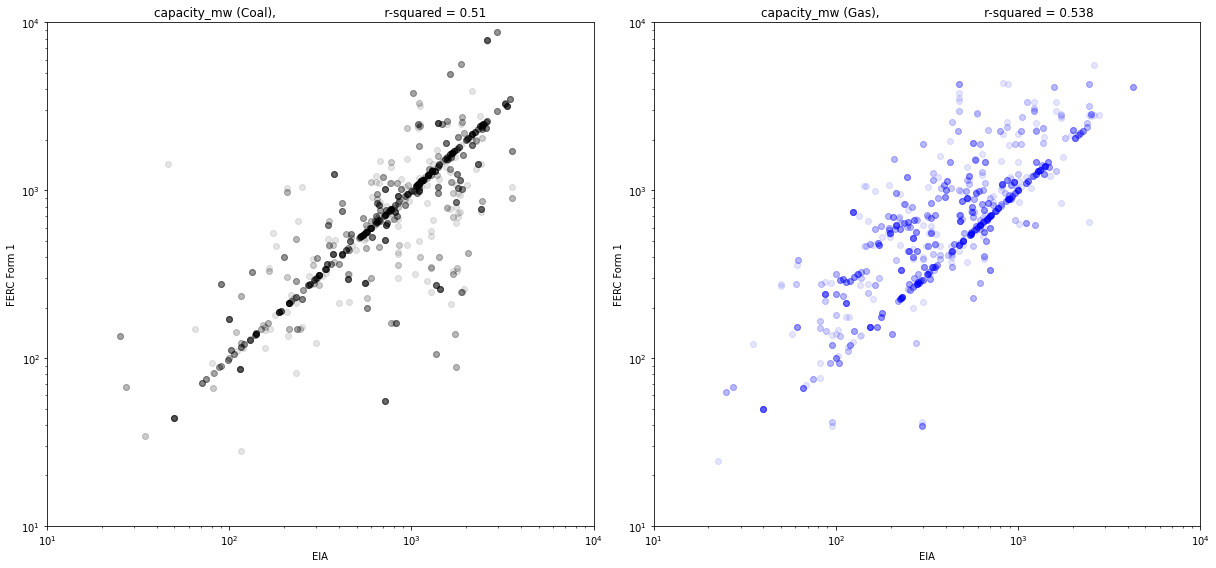

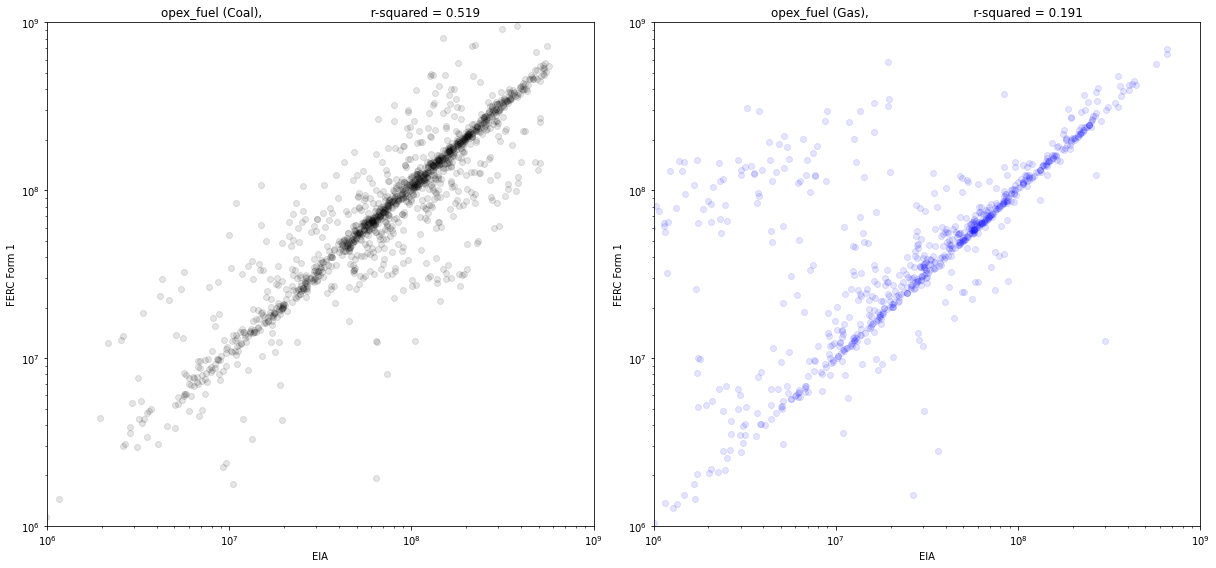

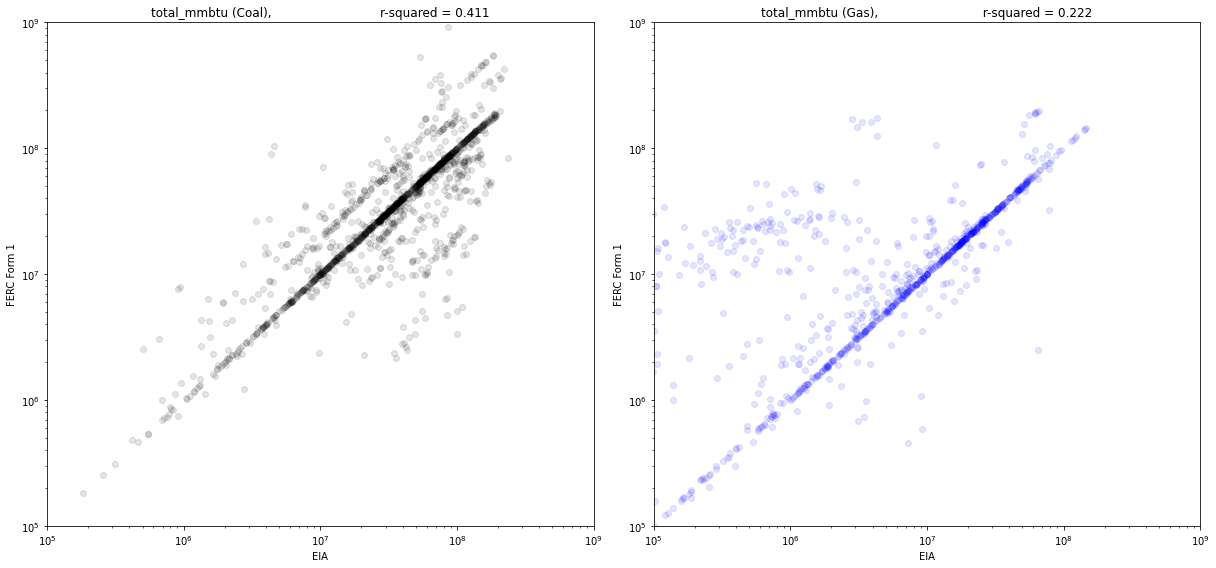

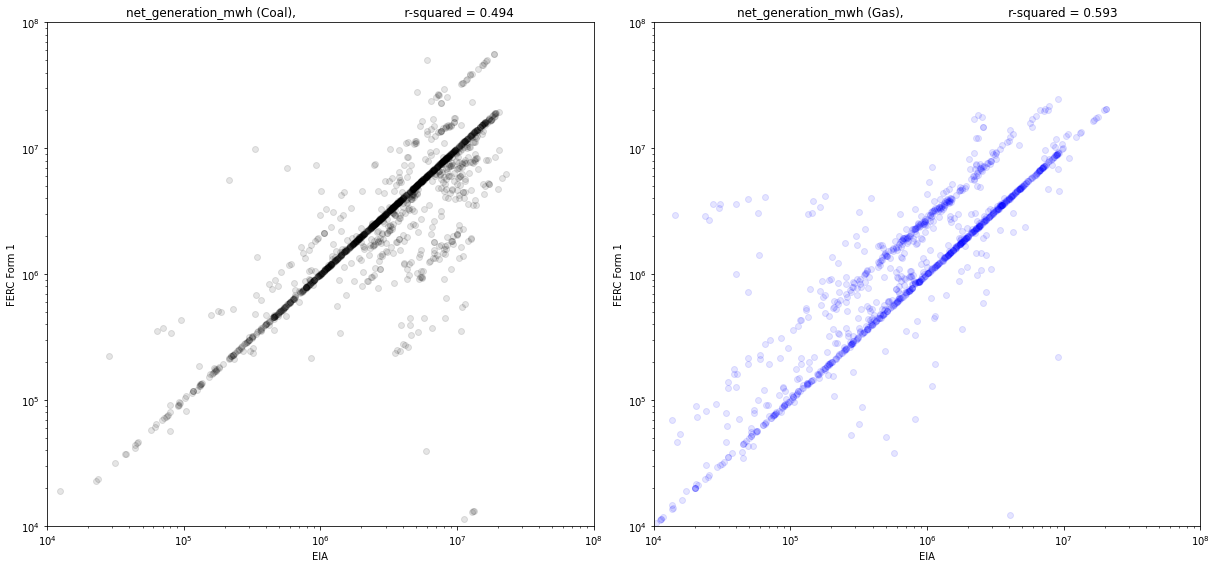

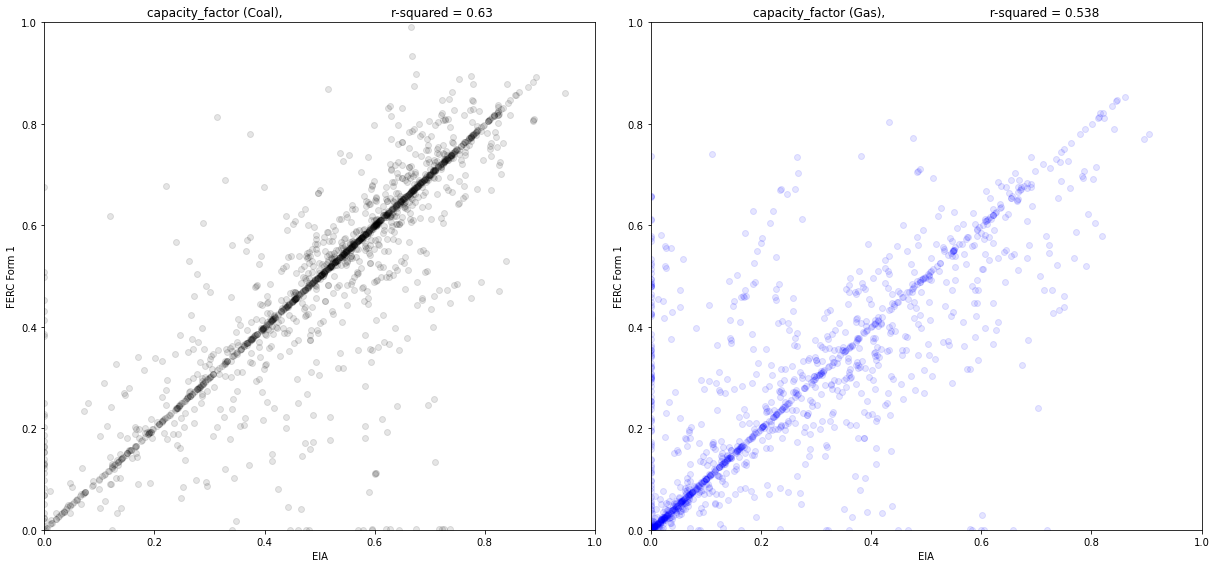

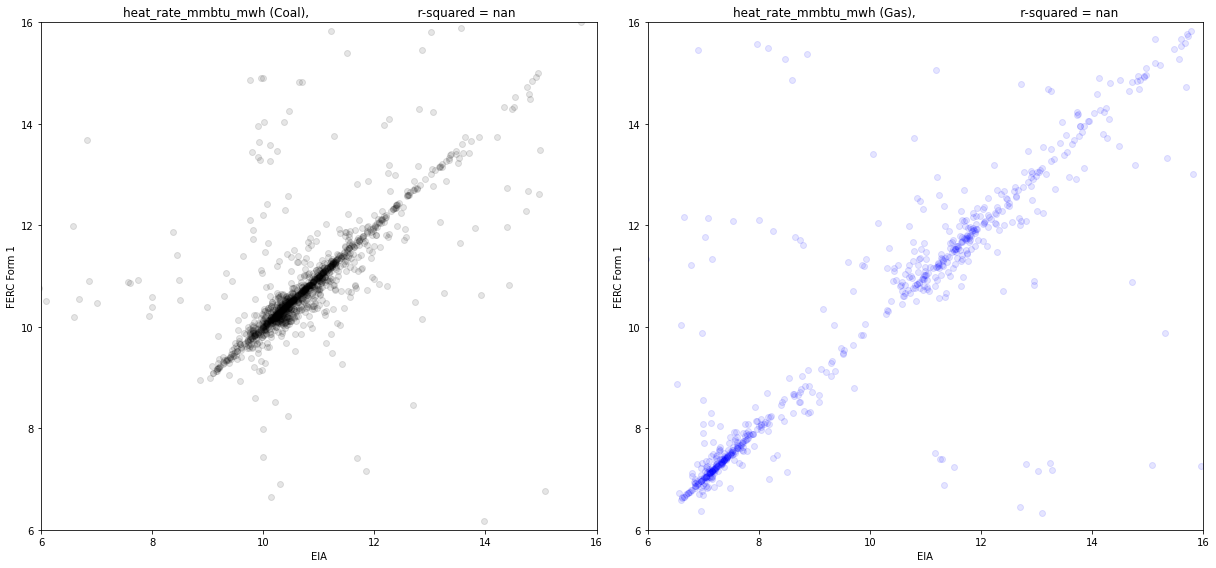

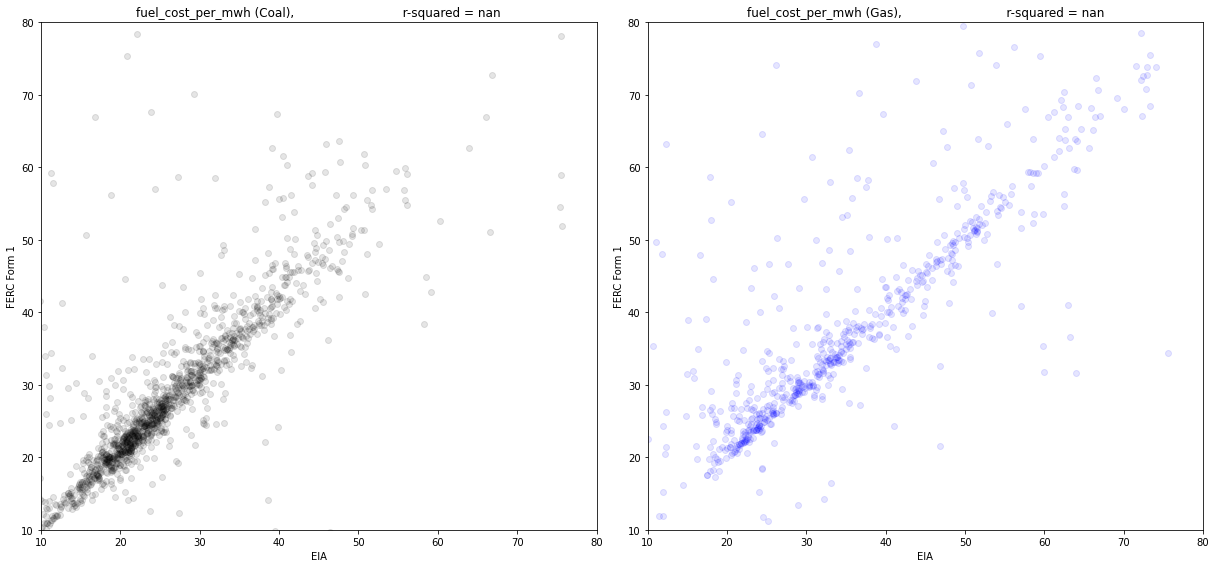

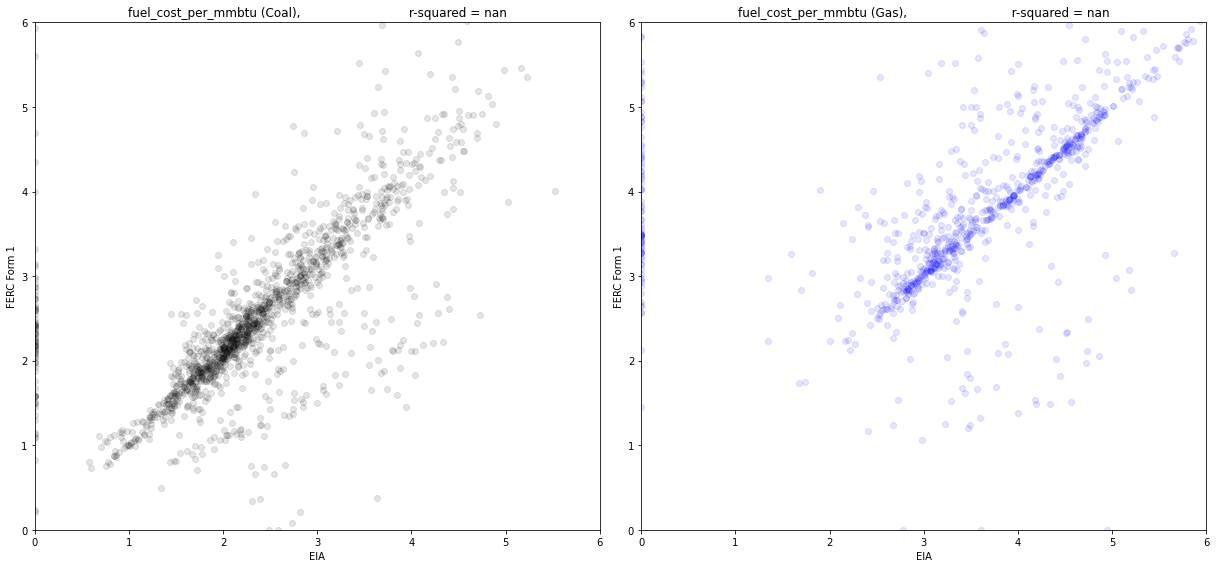

In [15]:
plot_eia_v_ferc(pudl_out)

### <a id='heatrate'>Heat Rate Comparison</a>

Prepping raw EIA data
Converting date to year
Calculating generator age
Eliminating retired plants
 - Comparing heat rates internally
Building Part 1 output
Finished compiling Part 1 unit-fuel level data


/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


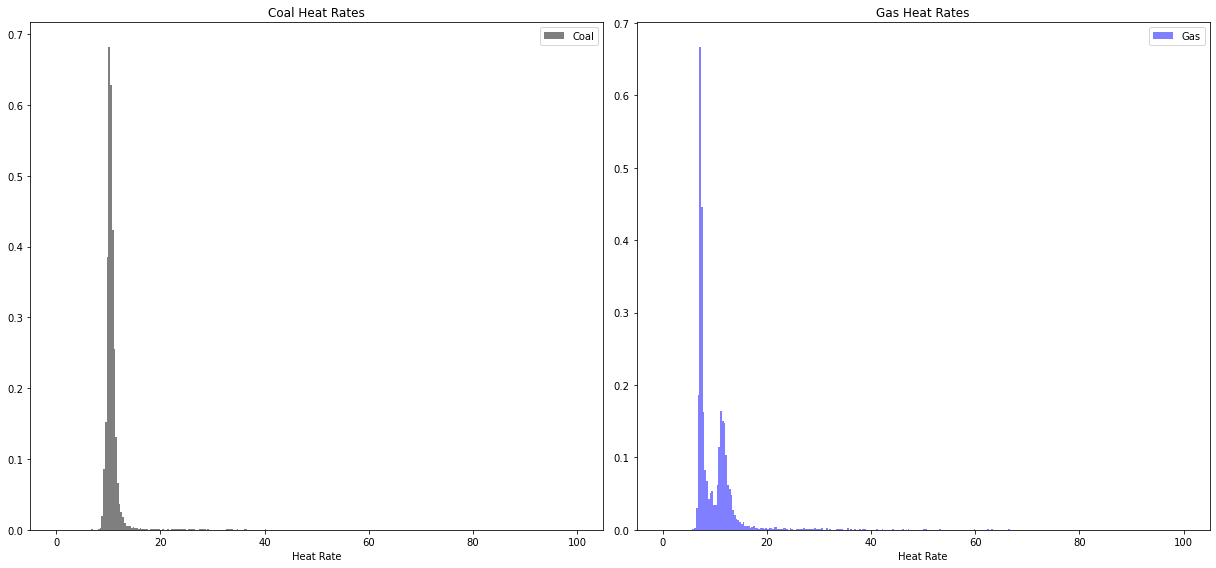

In [16]:
plot_heat_rate(pudl_out)

### <a id='mcoe-validate'>Check the MCOE Compilation</a>

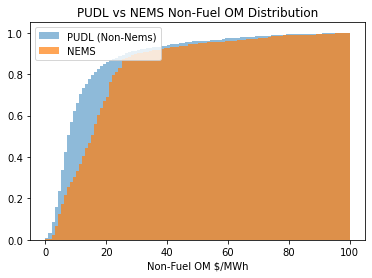

In [17]:
plant_non_nems = plant[(~plant.fix_var_is_NEMS)]
plt.hist(plant_non_nems.fix_var_om_mwh, density=True, cumulative=True, 
         range=(0,100), label='PUDL (Non-Nems)', alpha=.5,
         bins=100);

plt.hist((plant.fix_var_om_mwh_18_nems), density=True, cumulative=True, 
         range=(0,100), label='NEMS', alpha=.7,
         bins=100);
plt.xlabel('Non-Fuel OM $/MWh')
plt.legend()
plt.title("PUDL vs NEMS Non-Fuel OM Distribution")
plt.show()

this is a check to see the general shape of the fixed and variable O&M of the PUDL data is similar to NEMS

The following graph, we're simply plotting the components of MCOE against MCOE.
This should be just a straight line... which it appears to be, so yay.
The `mcoe` column has the least amount of records in it because it requires having both fuel cost data from EIA and fixed and variable cost data from FERC or NEMS.

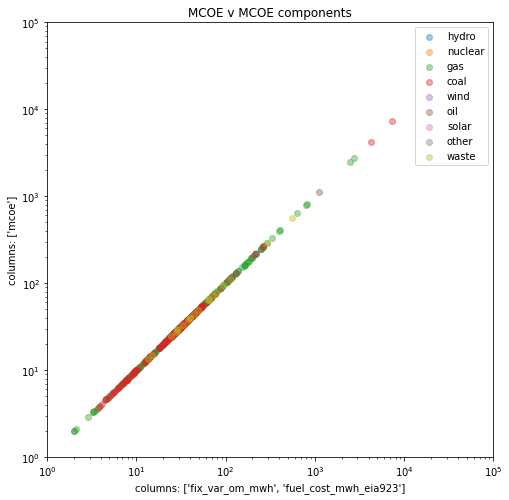

In [18]:
plot_mcoe_vs_nems(plant, 
                  x_cols=['mcoe'], y_cols=['fix_var_om_mwh','fuel_cost_mwh_eia923'], 
                  log=True, 
                  x_lim=(1,1e5), y_lim=(1,1e5),
                  alt_title='MCOE v MCOE components'
                 );

Now we are getting into comparing the components of MCOE. First let's compare the fixed and variable dollars per MWh.
Here are the plots

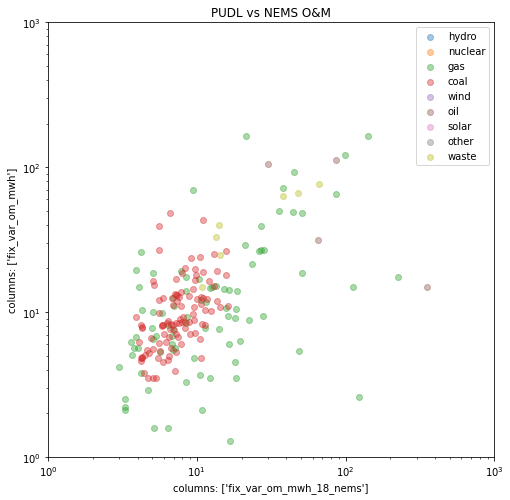

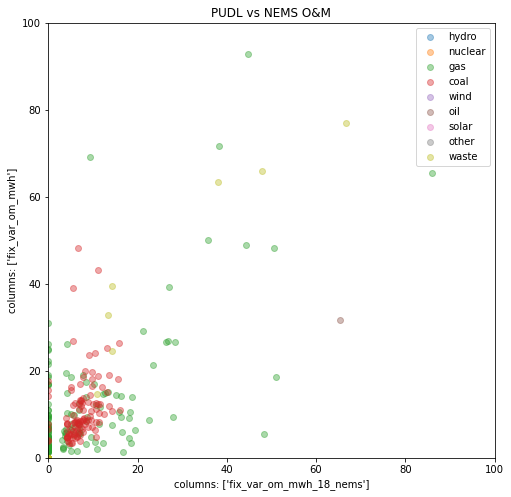

In [19]:
plot_mcoe_vs_nems(plant_non_nems, 
                  x_cols=['fix_var_om_mwh'], y_cols=['fix_var_om_mwh_18_nems'], 
                  log=True, 
                  x_lim=(1,1e3), y_lim=(1,1e3),
                  #fuels=['coal','gas']
                 );
plot_mcoe_vs_nems(plant_non_nems, 
                  x_cols=['fix_var_om_mwh'], y_cols=['fix_var_om_mwh_18_nems'], 
                  log=False, 
                  x_lim=(0,100), y_lim=(0,100),
                  #fuels=['coal','gas']
                 );

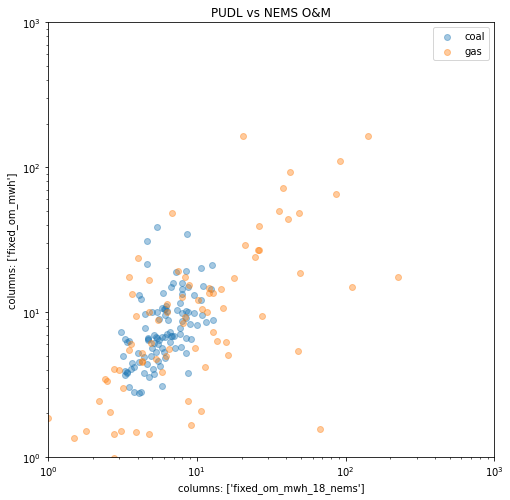

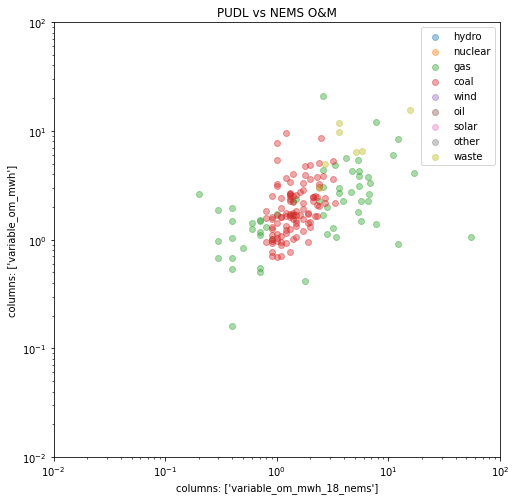

In [20]:
plot_mcoe_vs_nems(plant_non_nems, 
                  x_cols=['fixed_om_mwh'], y_cols=['fixed_om_mwh_18_nems'], 
                  log=True, 
                  x_lim=(1,1e3),
                  y_lim=(1,1e3), 
                  fuels=['coal','gas']
                 );
plot_mcoe_vs_nems(plant_non_nems, 
                  x_cols=['variable_om_mwh'], y_cols=['variable_om_mwh_18_nems'], 
                  log=True, 
                  x_lim=(.01,1e2),
                  y_lim=(.01,1e2)
                 );

There are the total fixed and variable dollar amounts. They look quite reasonable against NEMS totals.

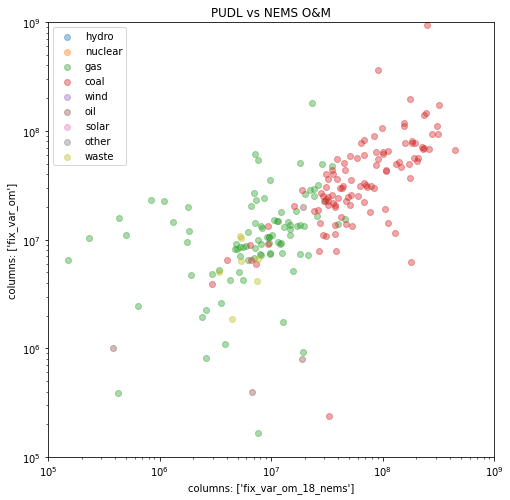

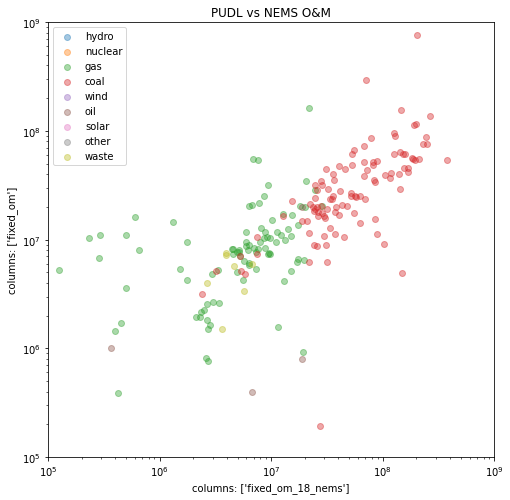

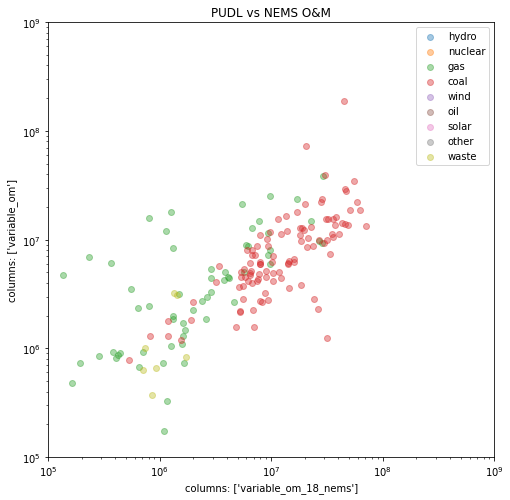

In [21]:
plot_mcoe_vs_nems(plant, 
                  x_cols=['fix_var_om'], y_cols=['fix_var_om_18_nems'], 
                  log=True, 
                  x_lim=(1e5,1e9),
                  y_lim=(1e5,1e9)
                 );
plot_mcoe_vs_nems(plant, 
                  x_cols=['fixed_om'], y_cols=['fixed_om_18_nems'], 
                  log=True, 
                  x_lim=(1e5,1e9),
                  y_lim=(1e5,1e9)
                 );
plot_mcoe_vs_nems(plant, 
                  x_cols=['variable_om'], y_cols=['variable_om_18_nems'], 
                  log=True, 
                  x_lim=(1e5,1e9),
                  y_lim=(1e5,1e9)
                 );

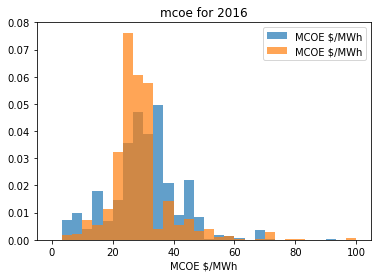

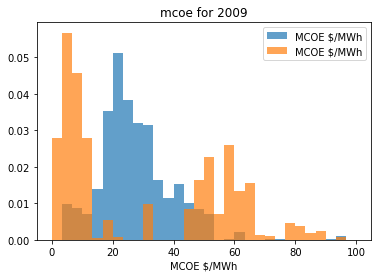

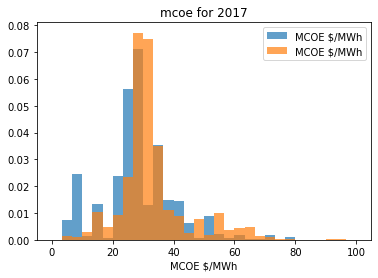

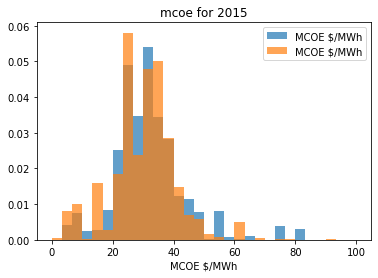

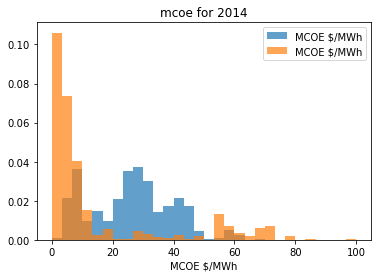

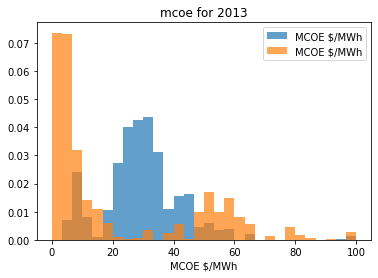

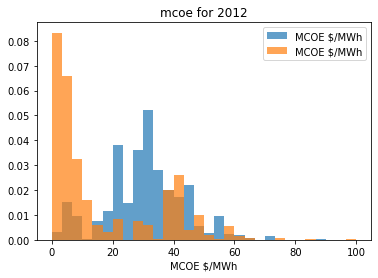

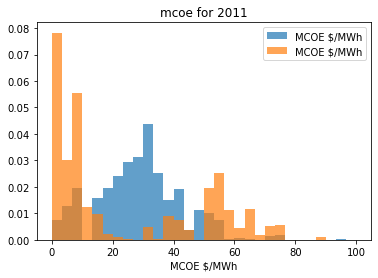

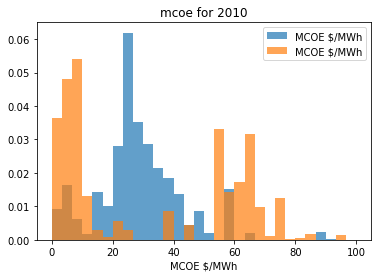

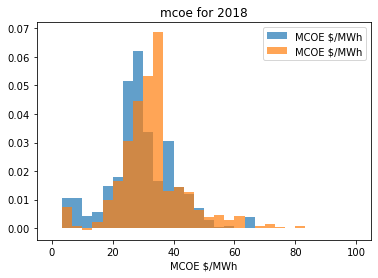

In [22]:
plot_hist_annual(plant_non_nems, 'mcoe', "MCOE $/MWh")

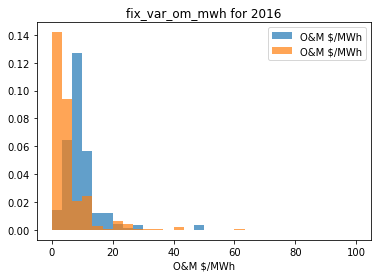

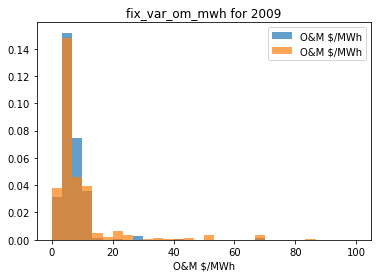

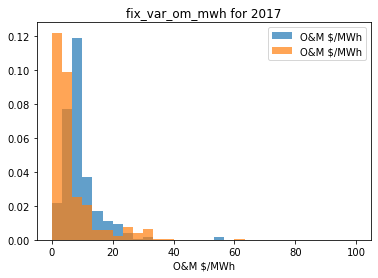

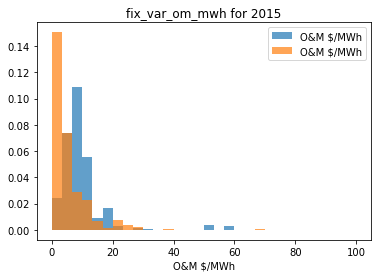

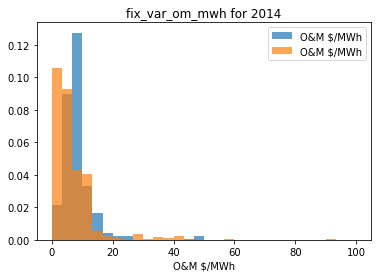

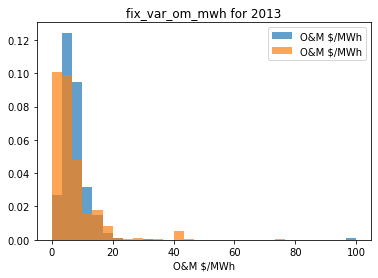

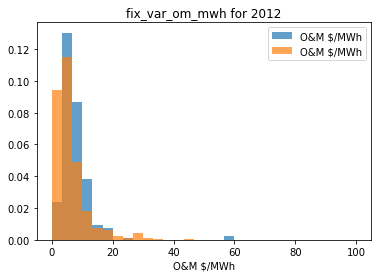

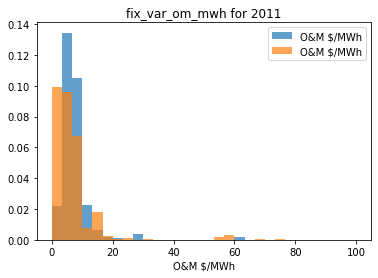

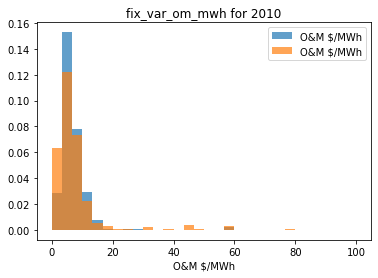

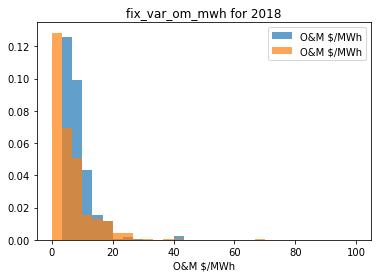

In [23]:
plot_hist_annual(plant, 'fix_var_om_mwh', "O&M $/MWh")

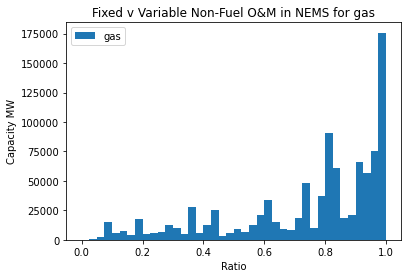

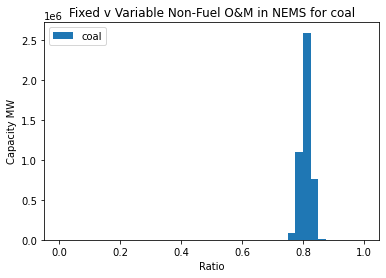

In [24]:
# this is a brief exploration of the split between fixed and variable costs from NEMS.
# there are clear patterns/differences between coal and gas.
# right now, we aren't using fuel type averages to break out fixed and variable costs
# but we could for the records which don't have associated NEMS data

nems = prep_nems(pudl_out)
fuel_tpyes= nems.fuel_type_code_pudl.unique()
#for fuel_type in fuel_tpyes:
for fuel_type in ['gas','coal']:
    df = nems[nems.fuel_type_code_pudl == fuel_type]
    plt.hist(df.fixed_v_total_ratio, 
             range=(0,1),
             weights=df.capacity_mw, 
             label=f'{fuel_type}',
             bins=40
            )
    plt.title(f"Fixed v Variable Non-Fuel O&M in NEMS for {fuel_type}")
    plt.xlabel("Ratio")
    plt.ylabel("Capacity MW")
    plt.legend(loc='upper left')
    plt.show()

In [25]:
nems[nems.fuel_type_code_pudl == 'gas'].capacity_mw.sum()/nems[nems.fuel_type_code_pudl == 'coal'].capacity_mw.sum()

0.21374800289526424

In [26]:
nems[nems.fuel_type_code_pudl == 'gas'].capacity_mw.sum()

972539.2

In [27]:
nems[nems.fuel_type_code_pudl == 'coal'].fixed_v_total_ratio.mean()

0.8094948082577416

In [28]:
nems[nems.fuel_type_code_pudl == 'gas'].fixed_v_total_ratio.std()

0.2620167229348759

In [30]:
# this is here just to be able tdescribeook at a sampling of the plant output
plant[(plant.fixed_om_mwh.notnull())
       #& (plant.fuel_type_code_pudl.isin(['coal','gas']))
       & (~plant.fix_var_is_NEMS)
       & (plant.variable_om_mwh_18_nems.notnull())
      ][
    ['report_year','mcoe', 
     'fixed_om', 'fixed_om_18_nems',
     
     'fuel_cost_mwh_eia923', 'fix_var_om_mwh', 'variable_om_mwh', 'fixed_om_mwh',
     'fix_var_om_mwh_18_nems', 'variable_om_mwh_18_nems','fixed_om_mwh_18_nems',
     'fix_var_om',
     'total_fuel_cost',
     'fuel_type_code_pudl',
     'fix_var_is_NEMS','plant_id_pudl'
    ]].round(1).sample(10)

,report_year,mcoe,fixed_om,fixed_om_18_nems,fuel_cost_mwh_eia923,fix_var_om_mwh,variable_om_mwh,fixed_om_mwh,fix_var_om_mwh_18_nems,variable_om_mwh_18_nems,fixed_om_mwh_18_nems,fix_var_om,total_fuel_cost,fuel_type_code_pudl,fix_var_is_NEMS,plant_id_pudl
3746,2018,28.7,9593403.8,5960131.3,25.8,2.9,2.3,0.6,4.7,3.9,0.8,47967019.0,433160220.8,gas,False,381
6079,2018,28.9,23787091.2,34820638.6,23.5,5.4,1.1,4.4,5.7,1.1,4.6,29733864.0,128267682.4,coal,False,624
5927,2018,6.2,34667653.6,27972327.2,0.0,6.2,1.2,5.0,4.1,0.9,3.2,43334567.0,0.0,coal,False,613
1679,2018,39.1,40442527.2,36024330.6,21.0,18.1,3.6,14.5,9.9,2.0,7.9,50553159.0,58533913.7,coal,False,167
5711,2018,46.1,7761656.7,5179388.9,32.0,14.1,1.4,12.7,8.5,0.6,7.9,8624063.0,16840546.7,gas,False,596
6389,2018,22.5,12834160.8,33731088.7,15.4,7.1,1.4,5.7,7.3,1.5,5.8,16042701.0,34750393.4,coal,False,654
6297,2018,63.4,5725428.3,4629516.2,0.0,63.4,6.3,57.1,38.0,5.1,32.9,6361587.0,0.0,waste,False,644
5869,2018,43.1,44368231.2,31171311.9,24.3,18.8,3.8,15.0,11.1,2.3,8.8,55460289.0,72000041.0,coal,False,607
5081,2018,34.4,53562682.4,373268511.2,25.8,8.6,1.7,6.9,8.0,1.3,6.7,66953353.0,397771002.3,coal,False,527
5661,2018,53.6,8247055.0,4572146.5,34.5,19.1,0.0,19.1,7.8,0.3,7.5,8247055.0,14874014.9,gas,False,590


In [31]:
# quick exploration of 
plant_18 = plant[plant.report_year == 2018]
logger.info(f'all 2018 records:    {len(plant_18)}')
logger.info(f'2018 records w/ferc: {len(plant_18[plant_18.fix_var_om_mwh.notnull()])}')
logger.info(f'2018 records w/nems: {len(plant_18[plant_18.fix_var_om_mwh_18_nems.notnull()])}')
logger.info(f'2018 records w/eia:  {len(plant_18[plant_18.fuel_cost_mwh_eia923.notnull()])}')
logger.info(f'2018 records w/moce: {len(plant_18[plant_18.mcoe.notnull()])}')

all 2018 records:    10893
2018 records w/ferc: 5175
2018 records w/nems: 5098
2018 records w/eia:  1229
2018 records w/moce: 543


In [32]:
# quick exploration of capacity
plant_18 = plant[plant.report_year == 2018]
plant_18_coal_gas = plant_18[plant_18.fuel_type_code_pudl.isin(['coal','gas'])]
logger.info(f'all 2018 capacity:    {(plant_18_coal_gas.capacity_mw.sum())/plant_18_coal_gas.capacity_mw.sum():.01%}')
logger.info(f'2018 capacity w/ferc: {(plant_18_coal_gas[plant_18_coal_gas.fix_var_om_mwh.notnull()].capacity_mw.sum())/plant_18_coal_gas.capacity_mw.sum():.01%}')
logger.info(f'2018 capacity w/nems: {(plant_18_coal_gas[plant_18_coal_gas.fix_var_om_mwh_18_nems.notnull()].capacity_mw.sum())/plant_18_coal_gas.capacity_mw.sum():.01%}')
logger.info(f'2018 capacity w/eia:  {(plant_18_coal_gas[plant_18_coal_gas.fuel_cost_mwh_eia923.notnull()].capacity_mw.sum())/plant_18_coal_gas.capacity_mw.sum():.01%}')
logger.info(f'2018 capacity w/moce: {(plant_18_coal_gas[plant_18_coal_gas.mcoe.notnull()].capacity_mw.sum())/plant_18_coal_gas.capacity_mw.sum():.01%}')

all 2018 capacity:    100.0%
2018 capacity w/ferc: 59.2%
2018 capacity w/nems: 51.9%
2018 capacity w/eia:  69.4%
2018 capacity w/moce: 48.9%


In [33]:
# quick exploration of capacity
plant_18 = plant[plant.report_year == 2018]
plant_18_coal_gas = plant_18[plant_18.fuel_type_code_pudl.isin(['coal','gas','oil'])]
logger.info(f'all 2018 capacity:    {(plant_18_coal_gas.capacity_mw.sum())/plant_18_coal_gas.capacity_mw.sum():.01%}')
logger.info(f'2018 capacity w/ferc: {(plant_18_coal_gas[plant_18_coal_gas.fix_var_om_mwh.notnull()].capacity_mw.sum())/plant_18_coal_gas.capacity_mw.sum():.01%}')
logger.info(f'2018 capacity w/nems: {(plant_18_coal_gas[plant_18_coal_gas.fix_var_om_mwh_18_nems.notnull()].capacity_mw.sum())/plant_18_coal_gas.capacity_mw.sum():.01%}')
logger.info(f'2018 capacity w/eia:  {(plant_18_coal_gas[plant_18_coal_gas.fuel_cost_mwh_eia923.notnull()].capacity_mw.sum())/plant_18_coal_gas.capacity_mw.sum():.01%}')
logger.info(f'2018 capacity w/moce: {(plant_18_coal_gas[plant_18_coal_gas.mcoe.notnull()].capacity_mw.sum())/plant_18_coal_gas.capacity_mw.sum():.01%}')

all 2018 capacity:    100.0%
2018 capacity w/ferc: 59.0%
2018 capacity w/nems: 52.0%
2018 capacity w/eia:  67.8%
2018 capacity w/moce: 47.6%


In [34]:
# capacity coverage
plant_18[plant_18.mcoe.notnull()].capacity_mw.sum()/plant_18[plant_18.fuel_type_code_pudl.isin(['coal','gas'])].capacity_mw.sum()

0.4978369601779218

In [35]:
# net generation coverage
plant_18[plant_18.mcoe.notnull()].net_generation_mwh.sum()/plant_18[plant_18.fuel_type_code_pudl.isin(['coal','gas'])].net_generation_mwh.sum()

0.6999997037702452

In [36]:
# coal capacity coverage
(plant_18[(plant_18.mcoe.notnull())
          & plant_18.fuel_type_code_pudl.isin(['coal'])
         ].capacity_mw.sum()
 /plant_18[(plant_18.fuel_type_code_pudl.isin(['coal']))].capacity_mw.sum())

0.8819539010446165